<a href="https://colab.research.google.com/github/sandiridwan1/DLC/blob/main/UTS_ADL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Reproduce P1**

**Paper**: https://paperswithcode.com/paper/xnet-a-convolutional-neural-network-cnn

**XNet Model**: https://github.com/JosephPB/XNet

In [ ]:
!pip install matplotlib==3.0.2

In [ ]:
!pip install -U tensorflow-addons

In [ ]:
# Instalasi Modul

import numpy as np 
import tensorflow as tf
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow_addons as tfa
from google.colab import files
from tqdm import tqdm
from cv2 import imread, createCLAHE
from glob import glob
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
%matplotlib inline

**DATASET**

https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

Download Dataset Dari Kaggle

In [ ]:
# Install Kaggle

!pip install -U -q kaggle

In [ ]:
# Upload Authentication Kaggle

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"luckysimarda","key":"6219bf0c92fe947ff6c3c99575b45490"}'}

In [ ]:
# Persiapan Authentication Kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Download Data

!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels -p /content
!unzip -qq /content/chest-xray-masks-and-labels.zip
!rm -rf /content/chest-xray-masks-and-labels.zip
!rm -rf /content/data

100% 9.57G/9.58G [01:05<00:00, 198MB/s]
100% 9.58G/9.58G [01:05<00:00, 157MB/s]
replace Lung Segmentation/.ipynb_checkpoints/Montgomery-checkpoint.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Membaca Data

image_path = '/content/Lung Segmentation/CXR_png/'
mask_path = '/content/Lung Segmentation/masks/'

In [ ]:
# Ukuran Data

images = os.listdir(image_path)
mask = os.listdir(mask_path)

len(images), len(mask)

(800, 704)

In [ ]:
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [ ]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


**PERSIAPAN DATASET**

In [ ]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [ ]:
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [ ]:
# Load Training and Testing Data

dim = 256*2
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 138/138 [00:50<00:00,  2.71it/s]


training set


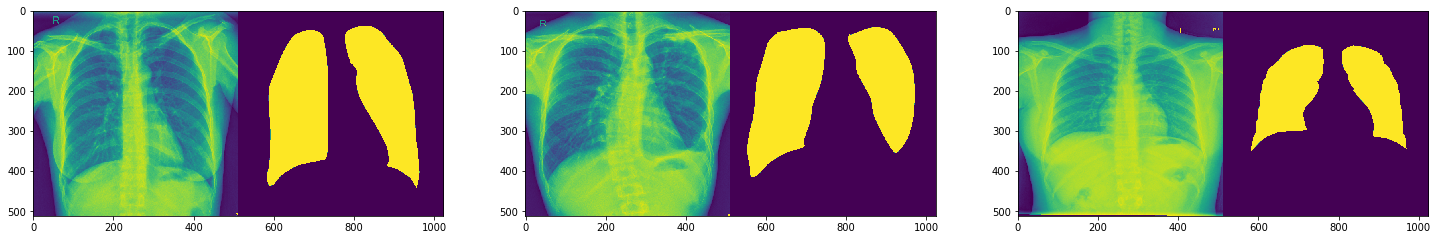

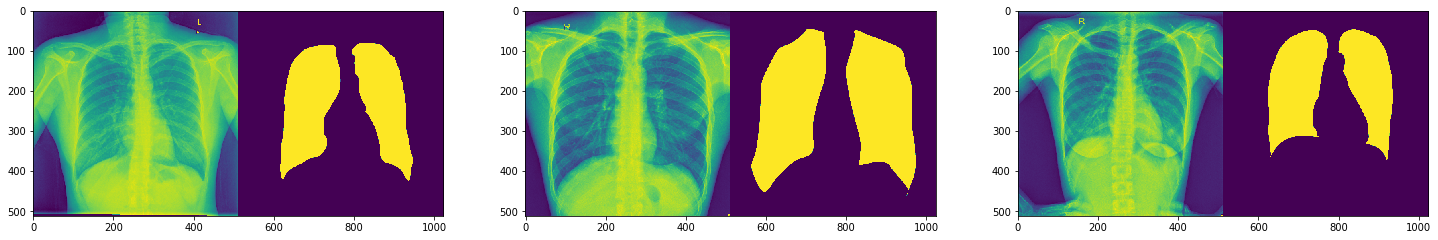

testing set


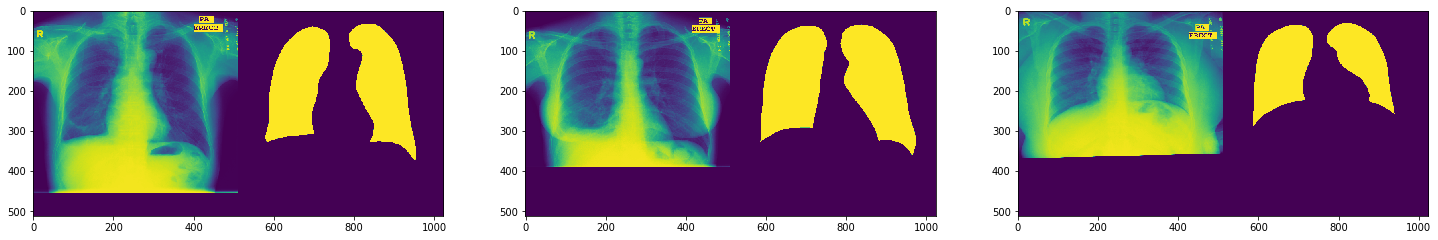

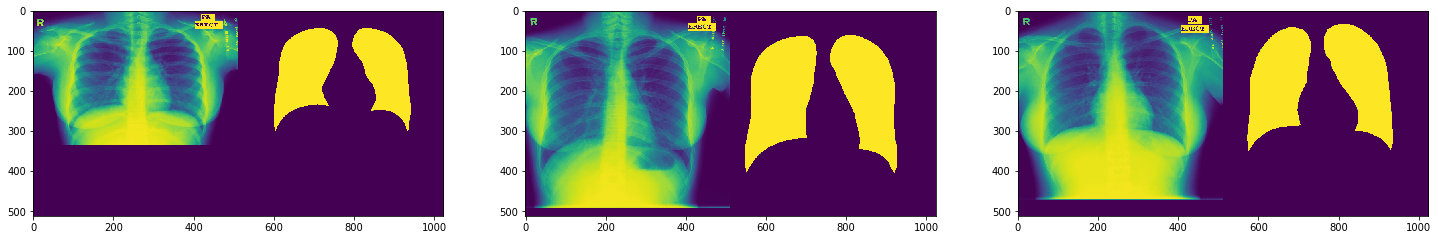

In [ ]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

In [ ]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

**SETUP THE MODEL**

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
def XNet(input_shape=(256,256,1)):
    inputs = Input(input_shape)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = XNet(input_shape=(dim, dim, 1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

**TRAIN THE MODEL**

In [ ]:
model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 50,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)


clear_output()

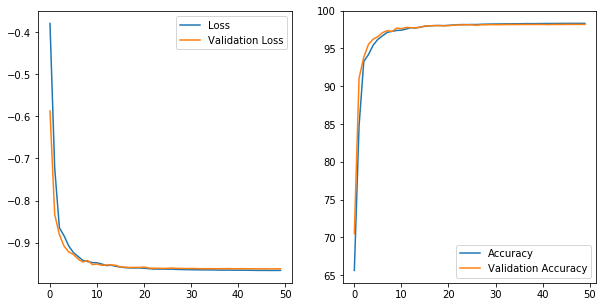

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

**TEST THE MODEL**

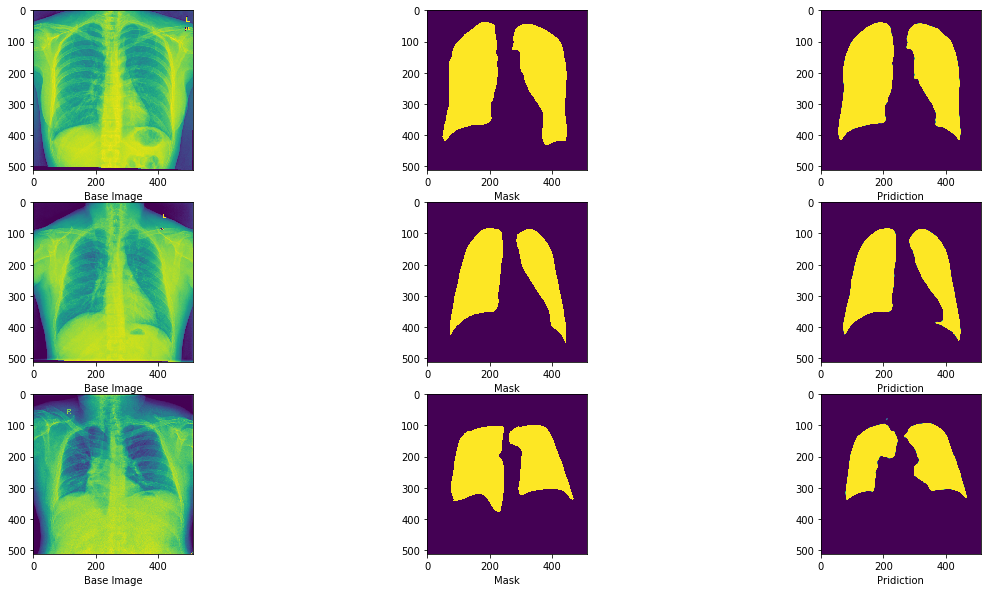

In [ ]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction")